**IMPORTS**

In [1]:
import os
import math
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import hilbert, butter, lfilter
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import joblib

**RUTAS Y TIPOS DE FRUTAS**

In [2]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']

training_path    = '../../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

**DICCIONARIO DE AUDIOS ORIGINALES**

In [3]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**DICCIONARIO DE AUDIOS PROCESADOS**

In [4]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

**PARAMETROS DEL AUDIO**

In [5]:
FRAME_SIZE = 512# In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

**FUNCIONES GENERALES DE AUDIO**

In [6]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [7]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [8]:
def rms(signal, frames, hop):
    return librosa.feature.rms(y=signal, frame_length = frames, hop_length = hop)

**FILTERS**

In [11]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [12]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [13]:
def preemphasis(signal, coef=0.97):
    return np.append(signal[0], signal[1:] - coef * signal[:-1])

In [14]:
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

In [15]:
def smooth_envelope(signal, sr, cutoff_frequency=50.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)

**PRROCCESSING OF THE AUDIO FILES FUNCTIONS**

In [16]:
def process(audio_in, audio_out, umbral = 0.295):
    signal, sr, duration = load_audio(audio_in)
    
    filtered = low_pass_filter(signal, sr, 1800)
    filtered = preemphasis(filtered, 0.999)

    rms_signal = rms(signal, 4096, 2048)

    rms_signal = normalize(rms_signal)
    drms = normalize(derivative(rms_signal, duration))

    audio_vector = time_vector(signal, duration)
    drms_vector = time_vector(drms, duration)

    left_index = np.argmax(np.abs(drms) > umbral)
    rigth_index = len(drms) - 1 - np.argmax(np.abs(np.flip(drms)) > umbral)

    left_time = drms_vector[left_index]
    rigth_time = drms_vector[rigth_index]

    mask_vector = audio_vector >= left_time

    audio_vector = audio_vector[mask_vector]
    trimed_signal = signal[mask_vector]

    mask_vector = audio_vector <= rigth_time

    audio_vector = audio_vector[mask_vector]
    trimed_signal = trimed_signal[mask_vector]

    sf.write(audio_out, trimed_signal, sr)

In [17]:
def process_audios(original:dict, processed:dict):
    already_processed = []
    for group in processed.values():
        already_processed.extend(group)
        
    for fruit, audios in original.items():
        for audio in audios:
            file = os.path.basename(audio)
            if file in already_processed:
                pass
            else:
                process(audio, os.path.join(processed_path, f"{fruit}/{file}"))

**PLOTTING**

In [18]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [19]:
#3d
def plot_features3d(features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))

    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

**AUDIO PROCESSING**

In [ ]:
process_audios(original, processed)

C:\Users\Juan\AppData\Local\Temp\ipykernel_1712\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


**FEATURES EXTRACTION**

*Features extraction function*

In [ ]:
'''def get_features(signal, sr, duration):
    split_frequency = 3000
    cuton = 20
    cutoff = 8500
    n_mfcc = 4
    feature = np.empty((1, 0))

    # Calculate the rms
    audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
    feat = audio_rms
    feature = np.append(feature, audio_rms)

    # Centroid
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    centroid /= np.max(np.abs(centroid))
    # std
    feat = np.std(centroid)/np.mean(centroid)
    feature = np.append(feature, feat)

    # Envelope RMS
    smoothed = rms(signal, FRAME_SIZE, HOP_SIZE)
    smoothed = smoothed.reshape(-1,)
    smoothed /= np.max(np.abs(smoothed))
    #std
    feat = np.std(smoothed)/np.mean(smoothed)
    feature = np.append(feature, feat)
    #momentum
    t = time_vector(smoothed, duration)
    feat = np.dot(smoothed, t)/np.sum(smoothed)
    feature = np.append(feature, feat)

    #ZCR
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    #mean
    feat = np.mean(zcr)
    feature = np.append(feature, feat)
    #std
    feat = np.std(zcr)/np.mean(zcr)
    feature = np.append(feature, feat)

    #MFCCS
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    #mean
    feat = np.mean(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)
    #maximum
    feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[3]
    feature = np.append(feature, feat)
            
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

    #std
    feat = np.std(mfccs, axis = 1)/np.mean(mfccs, axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)
    #momentum
    frames = range(mfccs.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
    feat = feat[0]
    feature = np.append(feature, feat)

    #hilbert envelope
    env = smooth_envelope(signal, sr, 45)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    env = env.reshape(-1,1)
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature'''

'def get_features(signal, sr, duration):\n    split_frequency = 3000\n    cuton = 20\n    cutoff = 8500\n    n_mfcc = 4\n    feature = np.empty((1, 0))\n\n    # Calculate the rms\n    audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)\n    feat = audio_rms\n    feature = np.append(feature, audio_rms)\n\n    # Centroid\n    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]\n    centroid /= np.max(np.abs(centroid))\n    # std\n    feat = np.std(centroid)/np.mean(centroid)\n    feature = np.append(feature, feat)\n\n    # Envelope RMS\n    smoothed = rms(signal, FRAME_SIZE, HOP_SIZE)\n    smoothed = smoothed.reshape(-1,)\n    smoothed /= np.max(np.abs(smoothed))\n    #std\n    feat = np.std(smoothed)/np.mean(smoothed)\n    feature = np.append(feature, feat)\n    #momentum\n    t = time_vector(smoothed, duration)\n    feat = np.dot(smoothed, t)/np.sum(smoothed)\n    feature = np.append(feature, feat)\n\n    #ZCR\n    filtered = band_

In [ ]:
'''def get_features(signal, sr, duration):
    split_frequency = 3000
    cuton = 20
    cutoff = 8500
    n_mfcc = 4
    feature = np.empty((1, 0))

    # Calculate the rms
    audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
    feat = audio_rms
    feature = np.append(feature, audio_rms)

    # Centroid
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    centroid /= np.max(np.abs(centroid))
    # std
    feat = np.std(centroid)/np.mean(centroid)
    #feature = np.append(feature, feat)

    # Envelope RMS
    smoothed = rms(signal, FRAME_SIZE, HOP_SIZE)
    smoothed = smoothed.reshape(-1,)
    smoothed /= np.max(np.abs(smoothed))
    #std
    feat = np.std(smoothed)/np.mean(smoothed)
    feature = np.append(feature, feat)
    #momentum
    t = time_vector(smoothed, duration)
    feat = np.dot(smoothed, t)/np.sum(smoothed)
    feature = np.append(feature, feat)

    #ZCR
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    #maximum
    feat = np.max(zcr[((len(zcr)*4)//5 - 5) : ((len(zcr)*4)//5 + 5)])
    feature = np.append(feature, feat)

    zcr /= np.max(np.abs(zcr))
    #mean
    feat = np.mean(zcr[((len(zcr)*2)//7 - 5) : ((len(zcr)*2)//7 + 5)])
    feature = np.append(feature, feat)
    #std
    feat = np.std(zcr)/np.mean(zcr)
    feature = np.append(feature, feat)
    


    #MFCCS
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    #mean
    feat = np.mean(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)
    #maximum
    feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[3]
    feature = np.append(feature, feat)
            
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

    #std
    feat = np.std(mfccs, axis = 1)/np.mean(mfccs, axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)
    #momentum
    frames = range(mfccs.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
    feat = feat[0]
    feature = np.append(feature, feat)

    #hilbert envelope
    env = smooth_envelope(signal, sr, 45)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    env = env.reshape(-1,1)
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature'''

'def get_features(signal, sr, duration):\n    split_frequency = 3000\n    cuton = 20\n    cutoff = 8500\n    n_mfcc = 4\n    feature = np.empty((1, 0))\n\n    # Calculate the rms\n    audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)\n    feat = audio_rms\n    feature = np.append(feature, audio_rms)\n\n    # Centroid\n    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]\n    centroid /= np.max(np.abs(centroid))\n    # std\n    feat = np.std(centroid)/np.mean(centroid)\n    #feature = np.append(feature, feat)\n\n    # Envelope RMS\n    smoothed = rms(signal, FRAME_SIZE, HOP_SIZE)\n    smoothed = smoothed.reshape(-1,)\n    smoothed /= np.max(np.abs(smoothed))\n    #std\n    feat = np.std(smoothed)/np.mean(smoothed)\n    feature = np.append(feature, feat)\n    #momentum\n    t = time_vector(smoothed, duration)\n    feat = np.dot(smoothed, t)/np.sum(smoothed)\n    feature = np.append(feature, feat)\n\n    #ZCR\n    filtered = band

In [ ]:

'''def get_features(signal, sr, duration):
    split_frequency = 3000
    cuton = 20
    cutoff = 8500
    n_mfcc = 4
    feature = np.empty((1, 0))

    # Calculate the rms
    audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
    feat = audio_rms
    feature = np.append(feature, audio_rms)

    # Centroid
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    centroid /= np.max(np.abs(centroid))
    # std
    feat = np.std(centroid)/np.mean(centroid)
    feature = np.append(feature, feat)
    #momentum
    frames = range(len(centroid))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)
    feat = np.dot(centroid, t)/np.sum(centroid)
    feature = np.append(feature, feat)

    # Envelope RMS
    smoothed = rms(signal, FRAME_SIZE, HOP_SIZE)
    smoothed = smoothed.reshape(-1,)
    smoothed /= np.max(np.abs(smoothed))
    #std
    feat = np.std(smoothed)/np.mean(smoothed)
    feature = np.append(feature, feat)
    #momentum
    t = time_vector(smoothed, duration)
    feat = np.dot(smoothed, t)/np.sum(smoothed)
    feature = np.append(feature, feat)

    #ZCR
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    #maximum
    feat = np.max(zcr[((len(zcr)*4)//5 - 5) : ((len(zcr)*4)//5 + 5)])
    feature = np.append(feature, feat)

    zcr /= np.max(np.abs(zcr))
    #mean
    feat = np.mean(zcr[((len(zcr)*2)//7 - 5) : ((len(zcr)*2)//7 + 5)])
    feature = np.append(feature, feat)
    #std
    feat = np.std(zcr)/np.mean(zcr)
    feature = np.append(feature, feat)
    


    #MFCCS
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    #mean
    feat = np.mean(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)
    #maximum
    feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[3]
    feature = np.append(feature, feat)
            
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

    #std
    feat = np.std(mfccs, axis = 1)/np.mean(mfccs, axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)
    #momentum
    frames = range(mfccs.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
    feat = feat[0]
    feature = np.append(feature, feat)

    #hilbert envelope
    env = smooth_envelope(signal, sr, 45)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    env = env.reshape(-1,1)
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature'''

*feature extraction*

In [20]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [21]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

*CON LA SIGUIENTE COMBINACIÓN DE PROPIEDADES ANDA BASTANTE BIEN*

In [ ]:
'''def get_features(signal, sr, duration):
    split_frequency = 3000
    cuton = 20
    cutoff = 8500
    n_mfcc = 4
    feature = np.empty((1, 0))

    # Calculate the rms
    audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
    feat = audio_rms
    #feature = np.append(feature, audio_rms)

    # Centroid
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    centroid /= np.max(np.abs(centroid))
    # std
    feat = np.std(centroid)/np.mean(centroid)
    #feature = np.append(feature, feat)
    #momentum
    frames = range(len(centroid))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)
    feat = np.dot(centroid, t)/np.sum(centroid)
    #feature = np.append(feature, feat)

    # Envelope RMS
    smoothed = rms(signal, FRAME_SIZE, HOP_SIZE)
    smoothed = smoothed.reshape(-1,)
    smoothed /= np.max(np.abs(smoothed))
    #std
    feat = np.std(np.abs(smoothed))/np.mean(np.abs(smoothed))
    feature = np.append(feature, feat)
    #momentum
    t = time_vector(smoothed, duration)
    feat = np.dot(smoothed, t)/np.sum(smoothed)
    #feature = np.append(feature, feat)

    #ZCR
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    #maximum
    feat = np.max(zcr[((len(zcr)*4)//5 - 5) : ((len(zcr)*4)//5 + 5)])
    feature = np.append(feature, feat)
    zcr /= np.max(np.abs(zcr))
    #mean
    feat = np.mean(zcr[((len(zcr)*2)//7 - 5) : ((len(zcr)*2)//7 + 5)])
    feature = np.append(feature, feat)
    #std
    feat = np.std(zcr)/np.mean(zcr)
    feature = np.append(feature, feat)
    #momentum
    frames = range(len(zcr))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)
    feat = np.dot(zcr, t)/np.sum(zcr)
    #feature = np.append(feature, feat)

    #MFCCS
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    #mean
    feat = np.mean(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[1]
    #feature = np.append(feature, feat)
    #maximum
    feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
    feat = feat[3]
    feature = np.append(feature, feat)
            
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

    #std
    feat = np.std(mfccs, axis = 1)/np.mean(mfccs, axis = 1)
    feat = feat[1]
    feature = np.append(feature, feat)
    #momentum
    frames = range(mfccs.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
    feat = feat[0]
    feature = np.append(feature, feat)

    #hilbert envelope
    env = smooth_envelope(signal, sr, 45)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    env = env.reshape(-1,1)
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)
    feat = env[10]
    #feature = np.append(feature, feat)
    feat = env[13]
    #feature = np.append(feature, feat)

    return feature'''

In [ ]:
def get_features(signal, sr, duration):
    feature = np.empty((1, 0))

    # BER
    spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    # max
    split_frequency = 600
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.max(np.abs(BER))
    feature = np.append(feature, feat)
    # min
    # 1
    split_frequency = 1900
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # 2
    split_frequency = 5000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # 3
    split_frequency = 9000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # std
    # 1
    split_frequency = 8000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(np.abs(BER))
    feat = np.std(BER)/np.mean(np.abs(BER))
    feature = np.append(feature, feat)
    # 2
    split_frequency = 1000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(np.abs(BER))
    feat = np.std(BER)/np.mean(np.abs(BER))
    feature = np.append(feature, feat)

    #ZCR
    cutoff = 5000
    cuton = 1000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    # mean
    feat = np.mean(zcr)
    feature = np.append(feature, feat)
    # maximum
    cutoff = 10000
    cuton = 10
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.max(np.abs(zcr))
    feature = np.append(feature, feat)
    # std
    cutoff = 10000
    cuton  = 20
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.std(zcr)/np.mean(np.abs(zcr))
    feature = np.append(feature, feat)
    # mean local
    cutoff = 5000
    cuton = 1000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    feat = np.mean(zcr[((len(zcr)*3)//14 - 5) : ((len(zcr)*3)//14 + 5)])
    feature = np.append(feature, feat)
    # local max
    cutoff = 10000
    cuton = 10
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.max(zcr[((len(zcr)*3)//4 - 10) : ((len(zcr)*3)//4 + 10)])
    feature = np.append(feature, feat)

    # Roll off
    cuton = 100
    cutoff = 8500
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
    roll_off /= np.max(np.abs(roll_off))
    # mean
    feat = np.mean(np.abs(roll_off))
    feature = np.append(feature, feat)
    # max
    cuton = 100
    cutoff = 8500
    filtred = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.55)[0]
    feat = np.max(np.abs(roll_off))
    feature = np.append(feature, feat)
    # std
    cutoff = 8500
    cuton = 50
    filtred = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
    roll_off /= np.max(np.abs(roll_off))
    feat = np.std(np.abs(roll_off))/np.mean(np.abs(roll_off))
    feature = np.append(feature, feat)

    #MFCCS
    n_mfcc = 4
    # 1
    cuton = 500
    cutoff = 5000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.max(mfccs, axis = 1)
    feature = np.append(feature, feat[3])
    
    # 2
    cuton = 10
    cutoff = 8000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
    feat = np.std(np.abs(mfccs), axis = 1)/np.mean(np.abs(mfccs), axis = 1)
    feature = np.append(feature, feat[3])

    # 3
    cuton = 10
    cutoff = 8000
    filtred = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
    mfccs = mfccs[:, ((mfccs.shape[1]*4) // 5 - 10):((mfccs.shape[1]*4) //5 + 10)]
    feat = np.std(np.abs(mfccs), axis=1) / np.mean(np.abs(mfccs), axis=1)
    feature = np.append(feature, feat[1])

    #envelope
    env = rms(signal, FRAME_SIZE, HOP_SIZE)
    env = env.reshape(-1,)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature

In [ ]:
def extract_features(processed:dict):
    features = dict.fromkeys(fruit_types)
    for fruit, audios in processed.items():
        features[fruit] = None
        
        for audio in audios:
            # Load the audio signal
            signal, sr, duration = load_audio(audio)
            feature = get_features(signal, sr, duration)
        
            if features[fruit] is not None:
                features[fruit] = np.vstack([features[fruit], feature])
            else:
                features[fruit] = feature
    return features

In [ ]:
features = extract_features(processed)

C:\Users\Juan\AppData\Local\Temp\ipykernel_1712\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


In [ ]:
#PCA and dump
whole            = np.concatenate(list(features.values()), axis=0)

#Aplicar PCA para obtener dos componentes principales
pca              = PCA(n_components = 3)
scaler           = StandardScaler()
whole_scaled     = scaler.fit_transform(whole)
reduced_features = pca.fit_transform(whole_scaled)

In [ ]:
#Paso 3: Crear un diccionario con las matrices reducidas
reduced = {}
start_idx = 0

for fruit, matrix in features.items():
    num_rows = matrix.shape[0]
    reduced[fruit] = reduced_features[start_idx:start_idx + num_rows, :]
    start_idx += num_rows

In [ ]:
model['pca']      = pca
model['features'] = reduced
model['scaler']   = scaler
joblib.dump(model, model_file)

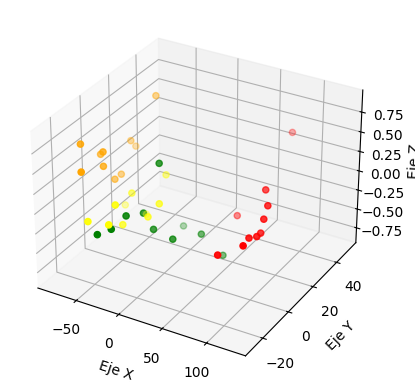

In [ ]:
plot_features3d(reduced)